In [49]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [50]:
from torchvision import datasets, transforms #torchvision is a helper library for vision tasks(like images)
# datasets contains ready-made datasets(like - MNIST, CIFAR-10, Fashion-MNIST)
# transforms is module for changing images into a form NN understands.

transform = transforms.ToTensor() # This line converts PIL images (Pthon imaging library)
# to tensor(A multi-dimensional array of numbers that supports gradients).
# NN understable numbers for math
# and calculations because NN needs numbers/continuous values
# here also (0,255) pixels --> (0,1)
# from (28 x 28) image --> (1, 28, 28) # this is called CHW format(channels, height, width)
# channel is required for CNNs but flattening can work both with channel or without channel
# flattening -> Convert multi-dimensional data into one long vector
# Flattening cares about number of elements, not channels
# Convolution cares deeply about channels

train_data = datasets.MNIST( # Create an object that represents the MNIST dataset in a form PyTorch can use
    root="./data",
    train=True,
    download=True,
    transform=transform
)

print(len(train_data)) # print the present number of training samples


60000


In [51]:
import torch
import torch.nn as nn # nn -> tools to build neural networks

In [52]:
# [28 x 28 image] -> flatten -> [784 inputs] -> [128 neurons] -> [ReLU] -> [10 outputs]
# create a NN Class
class SimpleNN(nn.Module): # nn.Module -> base class for all NNs
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,128)
    self.relu = nn.ReLU() # Rectified Linear Unit (Activation function)
    # ReLU -> value < 0 -> 0 or value >= 0 -> value
    # This add non-linearity in NN to learn complex patterns
    self.fc2 = nn.Linear(128,10)

  # define the forward method (how data flows through the network)
  def forward(self, x): # x -> input badge of images -> in this shape [batch_size, 1, 28, 28]
    x = x.view(-1, 784) # flatten image (bcz linear layer needs 1D vectors) -> now shape becomes [batch_size, 784]
    x = self.fc1(x) # input -> hidden
    x = self.relu(x) # activation
    x = self.fc2(x) # hidden -> output # output data shape [batch_size, 10]
    return x


In [53]:
from torch.utils.data import DataLoader
# Dataloader -> Takes your dataset,
# Splits it into mini-batches,
# Feeds them one by one during training
# why batches ? -> faster on GPU , more stable gradients, Fits in memory

train_loader = DataLoader(
    train_data, # this is your MNIST dataset
    batch_size=64, # processes 64 images together
    shuffle=True # Randomizes data order each epoch
)

print(len(train_loader))

938


In [54]:
# now, Move model & data to GPU (Tesla T4)
# GPU = much faster math for neural networks.
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# confirms if GPU is available or not

cuda


In [55]:
model = SimpleNN().to(device)
print(model)

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [56]:
# define loass function and optimizer

criterion = nn.CrossEntropyLoss()
# This is the standard loss for multi-class classification.

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# SGD -> Stochastic Gradient Descent -> weight = weight - lr * gradient
# lr -> learning rate -> too big (unstable), too small(slow learning)
# lr = 0.001 is safe for MNIST
# model.parameters() -> All weights + biases -> Automatically tracked by nn.Module
# use Adam optimizer (better than SGD)

In [57]:
# Training Loop (Forward + Backpropagation)

epochs = 5 # one full pass (as of now) overall 60,000 images
# can be increased later to 5 to 10

for epoch in range(epochs):
    for images, labels in train_loader:

        # Move data to GPU, already moved model to GPU before
        # Model and data should be on same location for training.(MUST)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step() # use gradients to update weights.Learning happens here

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [1/5], Loss: 0.0677
Epoch [2/5], Loss: 0.0994
Epoch [3/5], Loss: 0.0920
Epoch [4/5], Loss: 0.0154
Epoch [5/5], Loss: 0.0062


In [58]:
# Test Accuracy (if the network actually learned something ?)

# Load Test Dataset
test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

test_loader = DataLoader(
    test_data,
    batch_size=64,
    shuffle=False
)

# why seperate test dataset ? ->
# Training data → model learns from it
# Test data → model has never seen it
# This measures real performance

# now evaluation code
model.eval()   # evaluation mode

correct = 0
total = 0

with torch.no_grad():  # no gradient calculation -> saves meory -> faster evaluation
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")




Accuracy: 97.41%


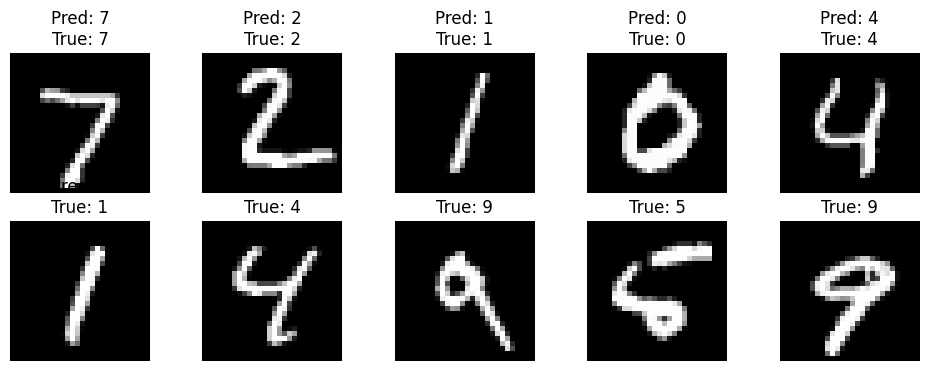

In [59]:
import matplotlib.pyplot as plt

model.eval()

images, labels = next(iter(test_loader))
# data load to GPU
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Move data back to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

plt.figure(figsize=(12, 4))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
    plt.axis("off")

plt.show()
